In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

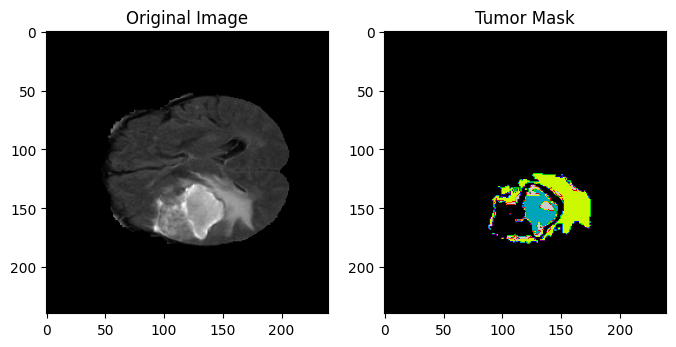

In [2]:
dataPath = 'HGG/'
num = 186 # Image with visable tumor
layer = 77 # about the middle of the brain

img = cv2.imread(f'{dataPath}flair/00000{num}/{layer}.png', cv2.IMREAD_GRAYSCALE) # Full image

# Masks are images of only the tumor
mask1 = cv2.imread(f'{dataPath}mask1/00000{num}/{layer}.png', cv2.IMREAD_GRAYSCALE)
mask2 = cv2.imread(f'{dataPath}mask2/00000{num}/{layer}.png', cv2.IMREAD_GRAYSCALE)
mask3 = cv2.imread(f'{dataPath}mask3/00000{num}/{layer}.png', cv2.IMREAD_GRAYSCALE)

mask1 = np.where(mask1 == 255, 1, 0)
mask2 = np.where(mask2 == 255, 2, 0)
mask3 = np.where(mask3 == 255, 3, 0)

mask = mask1 + mask2 + mask3

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='nipy_spectral')
plt.title('Tumor Mask')

plt.show()

In [3]:
# Region growing implementation
# Modified algorithm from https://dsp.stackexchange.com/questions/35138/region-growing-algorithm

def regionGrowing(img, seed, threshold=1):
    """
    Parameters:
    img (numpy.ndarray): Input image
    seed (tuple): Seed point (x, y)
    threshold (int): Threshold value for region growing

    Returns:
    numpy.ndarray: Binary image with the grown region
    """

    output = np.zeros_like(img)
    x, y = seed    
    
    pointsToCheck = [(x, y)]
    seedValue = img[x, y]
    
    while pointsToCheck:
        x, y = pointsToCheck.pop(0)
        
        # Check if the point is within the image bounds
        if x < 0 or x >= img.shape[0] or y < 0 or y >= img.shape[1]:
            continue
        
        # Check if the point has already been processed
        if output[x, y] == 1:
            continue
        
        currentValue = img[x, y]
        
        # Check if the intensity value is within the threshold
        if abs(int(currentValue) - int(seedValue)) <= threshold:
            # Mark the point as part of the region
            output[x, y] = 1
            
            # Add the neighboring points to the list of points to be checked
            pointsToCheck.append((x-1, y))
            pointsToCheck.append((x+1, y))
            pointsToCheck.append((x, y-1))
            pointsToCheck.append((x, y+1))
    
    return output

In [4]:
# Helper functions

def divideImage(img, blockSize=8):
    """ Divide the image into blocks of size blockSize x blockSize

    Parameters:
    img (numpy.ndarray): Input image
    blockSize (int): Size of the block

    Returns:
    list: List of blocks
    """

    blocks = []
    for i in range(0, img.shape[0], blockSize):
        for j in range(0, img.shape[1], blockSize):
            block = img[i:i+blockSize, j:j+blockSize]
            blocks.append(block)
    return blocks


def getBlockInfo(img):
    """ Uses divideImage to get information about the blocks in the image

    Parameters:
    img (numpy.ndarray): Input image

    Returns:
    imgBlocks (list): List of blocks
    blockAverages (list): List of average intensity values of the blocks
    blockCenters (list): List of center coordinates of the blocks
    """

    imgBlocks = divideImage(img, blockSize=8)

    blockAverages = []
    for block in imgBlocks:
        blockAverages.append(np.mean(block))

    blockCenters = []
    for i in range(0, img.shape[0], 8):
        for j in range(0, img.shape[1], 8):
            blockCenters.append((i+3, j+3))

    return imgBlocks, blockAverages, blockCenters


def getBiggestBlocks(blockAverages, imgBlocks, blockCenters, numBlocks=5):
    """ Get the biggest blocks based on the average intensity values

    Parameters:
    blockAverages (list): List of average intensity values of the blocks
    imgBlocks (list): List of blocks
    blockCenters (list): List of center coordinates of the blocks
    numBlocks (int): Number of biggest blocks to return

    Returns:
    biggestBlocks (list): List of biggest blocks
    biggestBlockCenters (list): List of center coordinates of the biggest blocks
    """

    biggestBlocks = []
    biggestBlockCenters = []
    
    for i in range(numBlocks):
        index = np.argmax(blockAverages)
        biggestBlocks.append(imgBlocks[index])
        biggestBlockCenters.append(blockCenters[index])
        blockAverages[index] = 0
    
        if len(biggestBlocks) > numBlocks:
            biggestBlocks.remove(min(biggestBlocks, key=lambda x: x.shape[0]*x.shape[1]))
            biggestBlockCenters.remove(min(biggestBlockCenters, key=lambda x: x[0]*x[1]))
    
    return biggestBlocks, biggestBlockCenters

[(139, 139), (171, 131), (139, 123), (147, 115), (147, 139)]


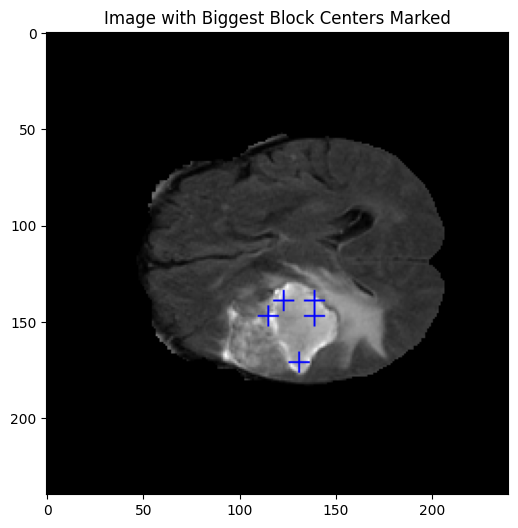

In [5]:
imgBlocks, blockAverages, blockCenters = getBlockInfo(img)
biggestBlocks, biggestBlockCenters = getBiggestBlocks(blockAverages, imgBlocks, blockCenters, numBlocks=5)

print(biggestBlockCenters)

imgCopy = np.copy(img)
imgCopy = cv2.cvtColor(imgCopy, cv2.COLOR_GRAY2RGB)
for center in biggestBlockCenters:
    cv2.drawMarker(imgCopy, (center[1], center[0]), (0, 0, 255), markerType=cv2.MARKER_CROSS, markerSize=10, thickness=1)

plt.figure(figsize=(6, 6))
plt.imshow(imgCopy)
plt.title('Image with Biggest Block Centers Marked')
plt.show()

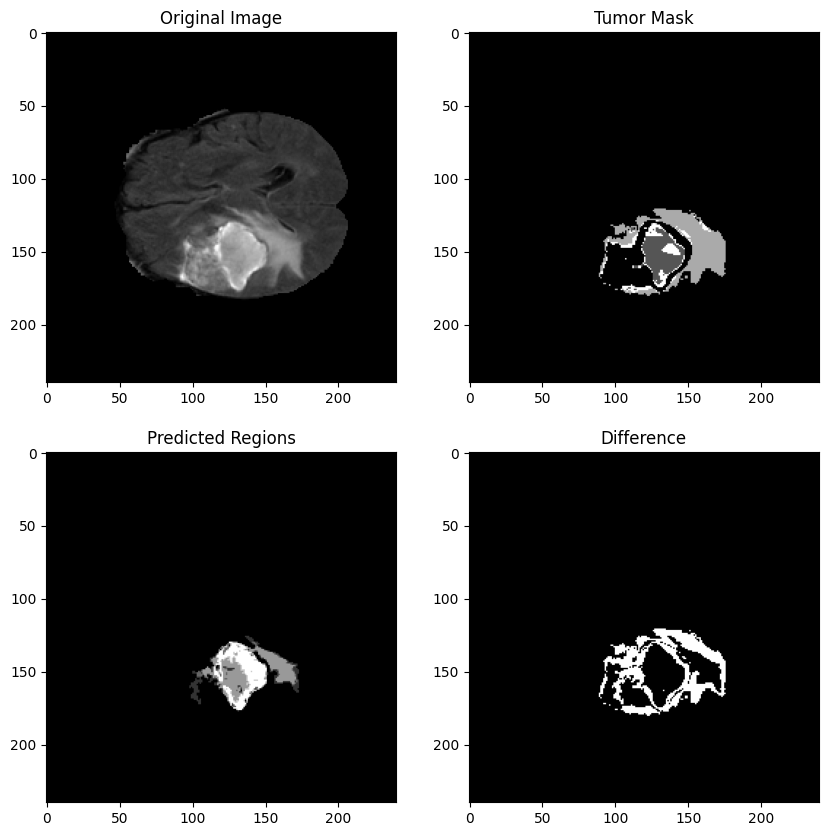

In [6]:
# Compare thte predicted regions with the actual tumor mask

predictedRegions = np.zeros_like(img)
for center in biggestBlockCenters:
    predictedRegions += regionGrowing(img, center, threshold=40)

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

plt.subplot(2, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Tumor Mask')

plt.subplot(2, 2, 3)
plt.imshow(predictedRegions, cmap='gray')
plt.title('Predicted Regions')

# sets the pixel value to 255 if it is greater than 0, else sets it to 0
mask = np.where(mask > 0, 255, 0)
predictedRegions = np.where(predictedRegions > 0, 255, 0)
# calculates the absolute difference between the mask and the predicted regions
difference = np.abs(mask - predictedRegions)

plt.subplot(2, 2, 4)
plt.imshow(difference, cmap='gray')
plt.title('Difference')

plt.show()

In [7]:
# Functions for getting the metrics for the predicted and actual regions

def getConfusionInfo(predicted, actual):
    """ Get the confusion matrix for the predicted and actual regions

    Parameters:
    predicted (numpy.ndarray): Predicted regions
    actual (numpy.ndarray): Actual regions

    Returns:
    tuple: True positives, false positives, true negatives, false negatives
    """

    truePositives = np.sum(np.logical_and(predicted == 255, actual == 255))
    falsePositives = np.sum(np.logical_and(predicted == 255, actual == 0))
    trueNegatives = np.sum(np.logical_and(predicted == 0, actual == 0))
    falseNegatives = np.sum(np.logical_and(predicted == 0, actual == 255))

    return truePositives, falsePositives, trueNegatives, falseNegatives

def extraFraction(predicted, actual):
    tp, fp, _, fn = getConfusionInfo(predicted, actual)
    return fp/(tp + fn) if tp + fn > 0 else 0


def overlapFraction(predicted, actual):
    tp, fp, _, _ = getConfusionInfo(predicted, actual)
    return tp/(tp + fp) if tp + fp > 0 else 0


def diceSimilarity(predicted, actual):
    tp, fp, _, fn = getConfusionInfo(predicted, actual)
    return tp /(.5 * (2*tp + fp + fn)) if tp + fp + fn > 0 else 0


def getMetrics(predicted, actual):
    """ Get the metrics for the predicted and actual regions

    Parameters:
    predicted (numpy.ndarray): Predicted regions
    actual (numpy.ndarray): Actual regions

    Returns:
    tuple: Extra fraction, overlap fraction, dice similarity
    """

    extra = extraFraction(predicted, actual)
    overlap = overlapFraction(predicted, actual)
    dice = diceSimilarity(predicted, actual)

    return extra, overlap, dice

In [8]:
ef, of, dss = getMetrics(predictedRegions, mask)

print(f'Extra Fraction: {ef}')
print(f'Overlap Fraction: {of}')
print(f'Dice Similarity Score: {dss}')

Extra Fraction: 0.21125611745513867
Overlap Fraction: 0.7063492063492064
Dice Similarity Score: 0.5910815939278937


In [9]:
# Function to find the best threshold

def findBestThreshold(dataPath, numImages=100, layer=77, numBlocks=5, thresholds=range(1, 51)):
    """ Find the best threshold for region growing

    Parameters:
    dataPath (str): Path to the data
    numImages (int): Number of images to consider
    layer (int): Layer to consider
    numBlocks (int): Number of blocks to consider
    thresholds (range): Threshold values to consider

    Returns:
    tuple: Best threshold, best Dice Similarity Score, best Extra Fraction, best Overlap Fraction
    """
    
    bestThreshold = 0
    bestDSS = 0
    bestEF = float('inf')
    bestOF = 0

    # Iterate over each threshold value
    for threshold in thresholds:
        totalDSS = 0
        totalEF = 0
        totalOF = 0

        # Iterate over each image
        for num in range(numImages):
            val = str(num).zfill(3)
            img = cv2.imread(f'{dataPath}flair/00000{val}/{layer}.png', cv2.IMREAD_GRAYSCALE)
            mask1 = cv2.imread(f'{dataPath}mask1/00000{val}/{layer}.png', cv2.IMREAD_GRAYSCALE)
            mask2 = cv2.imread(f'{dataPath}mask2/00000{val}/{layer}.png', cv2.IMREAD_GRAYSCALE)
            mask3 = cv2.imread(f'{dataPath}mask3/00000{val}/{layer}.png', cv2.IMREAD_GRAYSCALE)

            mask1 = np.where(mask1 == 255, 1, 0)
            mask2 = np.where(mask2 == 255, 2, 0)
            mask3 = np.where(mask3 == 255, 3, 0)

            mask = mask1 + mask2 + mask3

            # Get block information
            imgBlocks, blockAverages, blockCenters = getBlockInfo(img)
            biggestBlocks, biggestBlockCenters = getBiggestBlocks(blockAverages, imgBlocks, blockCenters, numBlocks=numBlocks)

            # Perform region growing
            predictedRegions = np.zeros_like(img)
            for center in biggestBlockCenters:
                predictedRegions += regionGrowing(img, center, threshold=threshold)

            predictedRegions = np.where(predictedRegions > 0, 255, 0)
            mask = np.where(mask > 0, 255, 0)

            # Get metrics
            ef, of, dss = getMetrics(predictedRegions, mask)

            totalDSS += dss
            totalEF += ef
            totalOF += of

        avgDSS = totalDSS / numImages
        avgEF = totalEF / numImages
        avgOF = totalOF / numImages

        # Update best threshold based on metrics
        if avgDSS > bestDSS or (avgDSS == bestDSS and avgEF < bestEF) or (avgDSS == bestDSS and avgEF == bestEF and avgOF > bestOF):
            bestThreshold = threshold
            bestDSS = avgDSS
            bestEF = avgEF
            bestOF = avgOF

    return bestThreshold, bestDSS, bestEF, bestOF

# Example usage
dataPath = 'HGG/'
bestThreshold, bestDSS, bestEF, bestOF = findBestThreshold(dataPath)
print(f'Best Threshold: {bestThreshold}')
print(f'Best Dice Similarity Score: {bestDSS}')
print(f'Best Extra Fraction: {bestEF}')
print(f'Best Overlap Fraction: {bestOF}')

Best Threshold: 33
Best Dice Similarity Score: 0.47107168413521394
Best Extra Fraction: 14.871249843982199
Best Overlap Fraction: 0.5719583805051085


In [10]:
# Function to find the best number of blocks
# 5 blocks seems to be the best number of blocks for this dataset
# does significantly worse past 5 blocks

def findBestBlockCount(dataPath, numImages=200, layer=77, blocks=range(1,6), threshold=30):
    """ Find the best number of blocks for region growing

    Parameters:
    dataPath (str): Path to the data
    numImages (int): Number of images to consider
    layer (int): Layer to consider
    blocks (range): Number of blocks to consider
    threshold (int): Threshold value for region growing

    Returns:
    tuple: Best number of blocks, best Dice Similarity Score
    best Extra Fraction, best Overlap Fraction
    """
    
    bestBlockCount = 0
    bestDSS = 0
    bestEF = float('inf')
    bestOF = 0

    # Iterate over each block count
    for block in blocks:
        totalDSS = 0
        totalEF = 0
        totalOF = 0

        # Iterate over each image
        for num in range(numImages):
            val = str(num).zfill(3)
            img = cv2.imread(f'{dataPath}flair/00000{val}/{layer}.png', cv2.IMREAD_GRAYSCALE)
            mask1 = cv2.imread(f'{dataPath}mask1/00000{val}/{layer}.png', cv2.IMREAD_GRAYSCALE)
            mask2 = cv2.imread(f'{dataPath}mask2/00000{val}/{layer}.png', cv2.IMREAD_GRAYSCALE)
            mask3 = cv2.imread(f'{dataPath}mask3/00000{val}/{layer}.png', cv2.IMREAD_GRAYSCALE)

            mask1 = np.where(mask1 == 255, 1, 0)
            mask2 = np.where(mask2 == 255, 2, 0)
            mask3 = np.where(mask3 == 255, 3, 0)

            mask = mask1 + mask2 + mask3

            # Get block information
            imgBlocks, blockAverages, blockCenters = getBlockInfo(img)
            _, biggestBlockCenters = getBiggestBlocks(blockAverages, imgBlocks, blockCenters, numBlocks=block)

            # Perform region growing
            predictedRegions = np.zeros_like(img)
            for center in biggestBlockCenters:
                predictedRegions += regionGrowing(img, center, threshold=threshold)

            predictedRegions = np.where(predictedRegions > 0, 255, 0)
            mask = np.where(mask > 0, 255, 0)

            # Get metrics
            ef, of, dss = getMetrics(predictedRegions, mask)

            totalDSS += dss
            totalEF += ef
            totalOF += of

        avgDSS = totalDSS / numImages
        avgEF = totalEF / numImages
        avgOF = totalOF / numImages

        # Prioritize Dice Similarity Score, then Extra Fraction, then Overlap Fraction
        if avgDSS > bestDSS or (avgDSS == bestDSS and avgEF < bestEF) or (avgDSS == bestDSS and avgEF == bestEF and avgOF > bestOF):
            bestBlockCount = block
            bestDSS = avgDSS
            bestEF = avgEF
            bestOF = avgOF

    return bestBlockCount, bestDSS, bestEF, bestOF

# Example usage
dataPath = 'HGG/'
bestBlockCount, bestDSS, bestEF, bestOF = findBestBlockCount(dataPath, threshold=bestThreshold)
print(f'Best number of blocks: {bestBlockCount}')
print(f'Best Dice Similarity Score: {bestDSS}')
print(f'Best Extra Fraction: {bestEF}')
print(f'Best Overlap Fraction: {bestOF}')

Best number of blocks: 5
Best Dice Similarity Score: 0.42582904405933375
Best Extra Fraction: 20.719937191603034
Best Overlap Fraction: 0.504065169437292


Before Adjusting the Image:
Extra Fraction: 15.55743879472693
Overlap Fraction: 0.055777803177506004
Dice Similarity Score: 0.10517241379310345

After Adjusting the Image:
Extra Fraction: 0.030131826741996232
Overlap Fraction: 0.9519519519519519
Dice Similarity Score: 0.7337962962962963


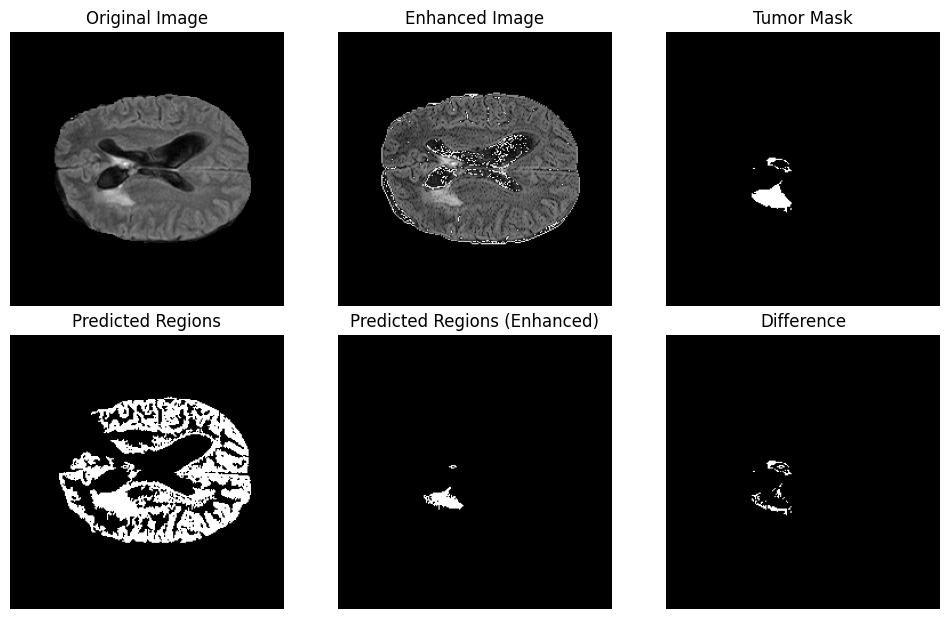

In [11]:
# Testing laplacian filters to enhance the image before applying region growing
# sometimes does better if the original method has a hard time finding the tumor

def LaplacianFilter(img):
    # Apply the Laplacian filter using OpenCV
    filteredImg = cv2.Laplacian(img, cv2.CV_64F)
    
    # Normalize the filtered image to the range 0-255
    filteredImg = np.clip(filteredImg, 0, 255)
    
    return filteredImg.astype(np.uint8)


dataPath = 'HGG/'
num = 201 # Image with visable tumor
num = str(num).zfill(3)
layer = 77 # about the middle of the brain

img = cv2.imread(f'{dataPath}flair/00000{num}/{layer}.png', cv2.IMREAD_GRAYSCALE) # Full image

# Masks are images of only the tumor
mask1 = cv2.imread(f'{dataPath}mask1/00000{num}/{layer}.png', cv2.IMREAD_GRAYSCALE)
mask2 = cv2.imread(f'{dataPath}mask2/00000{num}/{layer}.png', cv2.IMREAD_GRAYSCALE)
mask3 = cv2.imread(f'{dataPath}mask3/00000{num}/{layer}.png', cv2.IMREAD_GRAYSCALE)

mask1 = np.where(mask1 == 255, 1, 0)
mask2 = np.where(mask2 == 255, 2, 0)
mask3 = np.where(mask3 == 255, 3, 0)

mask = mask1 + mask2 + mask3

# Apply the Laplacian filter to enhance the image
filteredImg = LaplacianFilter(img).astype(float)
# Apply linear scaling to the filtered image - does better on lower thresholds
filteredImg = ((filteredImg - filteredImg.min()) / (filteredImg.max() - filteredImg.min()) * 255)
img_enhanced = (img.astype(float) - filteredImg).astype(np.uint8)


# Get block information for the original image
imgBlocks, blockAverages, blockCenters = getBlockInfo(img)
biggestBlocks, biggestBlockCenters = getBiggestBlocks(blockAverages, imgBlocks, blockCenters, numBlocks=bestBlockCount)

# Perform region growing on the original image
predictedRegions = np.zeros_like(img)
for center in biggestBlockCenters:
    predictedRegions += regionGrowing(img, center, threshold=33)

# Post-process the predicted regions
predictedRegions = np.where(predictedRegions > 0, 255, 0)
mask = np.where(mask > 0, 255, 0)

# Calculate metrics for the original image
ef, of, dss = getMetrics(predictedRegions, mask)
print("Before Adjusting the Image:")
print(f'Extra Fraction: {ef}')
print(f'Overlap Fraction: {of}')
print(f'Dice Similarity Score: {dss}')

# Get block information for the enhanced image
imgBlocks, blockAverages, blockCenters = getBlockInfo(img_enhanced)
biggestBlocks, biggestBlockCenters = getBiggestBlocks(blockAverages, imgBlocks, blockCenters, numBlocks=bestBlockCount)

# Perform region growing on the enhanced image
predictedRegionsEnhanced = np.zeros_like(img_enhanced)
for center in biggestBlockCenters:
    predictedRegionsEnhanced += regionGrowing(img_enhanced, center, threshold=33)

# Post-process the predicted regions for the enhanced image
predictedRegionsEnhanced = np.where(predictedRegionsEnhanced > 0, 255, 0)
mask = np.where(mask > 0, 255, 0)

# Calculate metrics for the enhanced image
ef, of, dss = getMetrics(predictedRegionsEnhanced, mask)
print("\nAfter Adjusting the Image:")
print(f'Extra Fraction: {ef}')
print(f'Overlap Fraction: {of}')
print(f'Dice Similarity Score: {dss}')

# Plot the results
fig, axes = plt.subplots(2, 3, figsize=(12, 10))

titles = ['Original Image', 'Enhanced Image', 'Tumor Mask', 'Predicted Regions', 'Predicted Regions (Enhanced)', 'Difference']
images = [img, img_enhanced, mask, predictedRegions, predictedRegionsEnhanced, np.abs(mask - predictedRegionsEnhanced)]

for ax, title, image in zip(axes.flatten(), titles, images):
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    ax.set_title(title)

plt.subplots_adjust(hspace=-0.35)  # Adjust the value as needed
plt.show()

In [12]:
def compareMetrics(dataPath, numImages=220, layer=77, numBlocks=5, threshold=33,):
    """ Compare the metrics for the original and enhanced images

    Parameters:
    dataPath (str): Path to the data
    numImages (int): Number of images to consider
    layer (int): Layer to consider
    numBlocks (int): Number of blocks to consider
    threshold (int): Threshold value for region growing

    Returns:
    tuple: Original metrics, Enhanced metrics
    """

    # Initialize metrics for original and enhanced images
    totalDssOriginal = 0
    totalEfOriginal = 0
    totalOfOriginal = 0
    
    totalDssEnhanced = 0
    totalEfEnhanced = 0
    totalOfEnhanced = 0

    # Iterate over each image
    for num in range(numImages):
        val = str(num).zfill(3)
        img = cv2.imread(f'{dataPath}flair/00000{val}/{layer}.png', cv2.IMREAD_GRAYSCALE)
        mask1 = cv2.imread(f'{dataPath}mask1/00000{val}/{layer}.png', cv2.IMREAD_GRAYSCALE)
        mask2 = cv2.imread(f'{dataPath}mask2/00000{val}/{layer}.png', cv2.IMREAD_GRAYSCALE)
        mask3 = cv2.imread(f'{dataPath}mask3/00000{val}/{layer}.png', cv2.IMREAD_GRAYSCALE)

        # Combine masks
        mask1 = np.where(mask1 > 0, 255, 0)
        mask2 = np.where(mask2 > 0, 255, 0)
        mask3 = np.where(mask3 > 0, 255, 0)
        mask = mask1 + mask2 + mask3

        # Original image processing
        imgBlocks, blockAverages, blockCenters = getBlockInfo(img)
        _, biggestBlockCenters = getBiggestBlocks(blockAverages, imgBlocks, blockCenters, numBlocks=numBlocks)

        predictedRegions = np.zeros_like(img)
        for center in biggestBlockCenters:
            predictedRegions += regionGrowing(img, center, threshold=threshold)

        predictedRegions = np.where(predictedRegions > 0, 255, 0)
        mask = np.where(mask > 0, 255, 0)

        # Calculate metrics for original image
        ef, of, dss = getMetrics(predictedRegions, mask)
        totalDssOriginal += dss
        totalEfOriginal += ef
        totalOfOriginal += of

        # Enhanced image processing
        filteredImg = LaplacianFilter(img).astype(float)
        filteredImg = ((filteredImg - filteredImg.min()) / (filteredImg.max() - filteredImg.min()) * 255)
        imgEnhanced = (img.astype(float) - filteredImg).astype(np.uint8)

        imgBlocks, blockAverages, blockCenters = getBlockInfo(imgEnhanced)
        _, biggestBlockCenters = getBiggestBlocks(blockAverages, imgBlocks, blockCenters, numBlocks=numBlocks)

        predictedRegionsEnhanced = np.zeros_like(imgEnhanced)
        for center in biggestBlockCenters:
            predictedRegionsEnhanced += regionGrowing(imgEnhanced, center, threshold=threshold)

        predictedRegionsEnhanced = np.where(predictedRegionsEnhanced > 0, 255, 0)
        mask = np.where(mask > 0, 255, 0)

        # Calculate metrics for enhanced image
        ef, of, dss = getMetrics(predictedRegionsEnhanced, mask)
        totalDssEnhanced += dss
        totalEfEnhanced += ef
        totalOfEnhanced += of

    # Calculate average metrics for original and enhanced images
    avgDssOriginal = totalDssOriginal / numImages
    avgEfOriginal = totalEfOriginal / numImages
    avgOfOriginal = totalOfOriginal / numImages

    avgDssEnhanced = totalDssEnhanced / numImages
    avgEfEnhanced = totalEfEnhanced / numImages
    avgOfEnhanced = totalOfEnhanced / numImages

    return (avgDssOriginal, avgEfOriginal, avgOfOriginal), (avgDssEnhanced, avgEfEnhanced, avgOfEnhanced)

# Example usage
dataPath = 'HGG/'
original_metrics, enhanced_metrics = compareMetrics(dataPath)
print(f'Original Metrics: DSS={round(original_metrics[0], 3)}, EF={round(original_metrics[1], 3)}, OF={round(original_metrics[2], 3)}')
print(f'Enhanced Metrics: DSS={round(enhanced_metrics[0], 3)}, EF={round(enhanced_metrics[1], 3)}, OF={round(enhanced_metrics[2], 3)}')

Original Metrics: DSS=0.419, EF=30.459, OF=0.492
Enhanced Metrics: DSS=0.401, EF=22.934, OF=0.491
